#Données de Haute-Frequence - Lab 1
ZHANG Mian \
CentraleSupélec

## 1. Import the data and labs

In [ ]:
!pip install powerlaw

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import os
import scipy.stats
import powerlaw
from statsmodels.graphics.tsaplots import plot_acf

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path = "/content/drive/MyDrive/TOTF.PA/"
l = os.listdir(path)
dfs = []
for name in l:
    if "quotes" in name:
        df = pd.read_csv(path+name)
        df = df[["ts","bp1","bq1","ap1","aq1"]]
        df["ts"] = pd.to_datetime(df["ts"])
        df["spread"] = df["ap1"] - df["bp1"]
        df["time_in_s"] = df["ts"].dt.hour*3600 + df["ts"].dt.minute*60 + df["ts"].dt.second + df["ts"].dt.microsecond/1000000
        df["mid_price"] = 0.5*(df["bp1"] + df["ap1"])
        df["weighted_price"] = (df["bp1"]*df["aq1"]+df["ap1"]*df["bq1"])/(df["bq1"] + df["aq1"])
        df["imbalance"] = (df["bq1"]-df["aq1"])/(df["bq1"] + df["aq1"])
        df["imbalance_bin"] = np.floor(5*df["imbalance"])/5
        dfs += [df]

In [6]:
dfs[0].head()

,ts,bp1,bq1,ap1,aq1,spread,time_in_s,mid_price,weighted_price,imbalance,imbalance_bin
0,2017-01-02 09:00:15.578,48.470,300,48.5,593,0.030,32415.578,48.4850,48.480078,-0.328108,-0.4
1,2017-01-02 09:00:15.578,48.470,100,48.5,593,0.030,32415.578,48.4850,48.474329,-0.711400,-0.8
2,2017-01-02 09:00:15.578,48.465,213,48.5,593,0.035,32415.578,48.4825,48.474249,-0.471464,-0.6
3,2017-01-02 09:00:15.578,48.465,100,48.5,593,0.035,32415.578,48.4825,48.470051,-0.711400,-0.8
4,2017-01-02 09:00:15.578,48.460,100,48.5,593,0.040,32415.578,48.4800,48.465772,-0.711400,-0.8


## 2 Multiple prices
Plot the bid price, ask price, mid price and weighted mid-price on a few minutes of your sample.

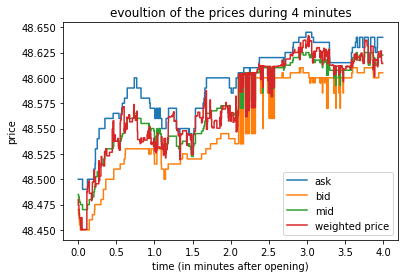

In [7]:
df = dfs[0]
n = np.sum(df["time_in_s"]<32415+60*4)
x = 4*np.arange(0,n,1)/n
fig,ax = plt.subplots()
ax.step(x,df["ap1"][df["time_in_s"]<32415+60*4])
ax.step(x,df["bp1"][df["time_in_s"]<32415+60*4])
ax.step(x,df["mid_price"][df["time_in_s"]<32415+60*4])
ax.step(x,df["weighted_price"][df["time_in_s"]<32415+60*4])
ax.set_xlabel("time (in minutes after opening)")
ax.set_ylabel("price")
ax.legend(["ask","bid","mid","weighted price"])
ax.set_title("evoultion of the prices during 4 minutes");

## 3 Spread distribution
- Plot a histogram of the spread distribution in event time (i.e. each observed value counts for one observation).
- Plot a histogram of the spread distribution in calendar time (i.e. each observed value is weighted by the length of the time interval on which it is observed).


In [8]:
spreads = []
for df in dfs:
    spreads += [df["spread"].to_numpy()]
spreads = np.concatenate(spreads)

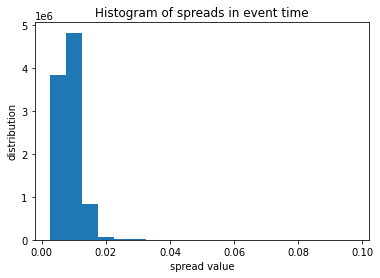

In [9]:
fig,ax = plt.subplots()
ax.hist(spreads, bins = [5*(i+0.5)/1000 for i in range(20)])
ax.set_xlabel("spread value")
ax.set_ylabel("distribution")
ax.set_title("Histogram of spreads in event time");

In [10]:
spreads = []
weights = []
for df in dfs:
    spreads += [df["spread"].to_numpy()[:-1]]
    weight = df["time_in_s"].diff().shift(-1).dropna()
    weights += [weight]
spreads = np.concatenate(spreads)
weights = np.concatenate(weights)

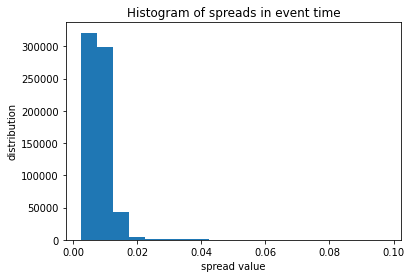

In [11]:
fig,ax = plt.subplots()
ax.hist(spreads, bins = [5*(i+0.5)/1000 for i in range(20)],weights = weights)
ax.set_xlabel("spread value")
ax.set_ylabel("distribution")
ax.set_title("Histogram of spreads in event time");

### Comments:
It is noticeable that the histogram in event time the most common spread (by a significant margin) is 0.01 (two ticks) whereas in calendar time, it is 0.005 (one tick), which means that events where the spread is two ticks are fixed quickly.

## 4. Imbalance and trading activity
- Compute the average mid-price movement as a function of the observed imbalance before the price movement
- Compute the mean executed/canceled quantity on each side of the LOB as a function of the observed imbalance before the price movement.


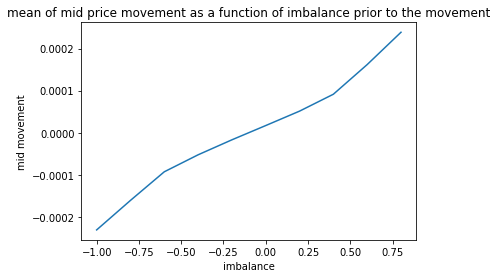

In [12]:
zs = np.zeros(10)
m = np.zeros(10)
for df in dfs:
    i = df["imbalance_bin"].to_numpy()[:-1]
    z1 = df["mid_price"].to_numpy()[:-1]
    z2 = df["mid_price"].to_numpy()[1:]
    z = z2-z1
    for j in range(10):
        b = (j-5)/5
        n = np.sum(i==b)
        m[j] += n
        zs[j] += n*np.mean(z[i==b])
zs = zs/m
fig,ax = plt.subplots()
ax.plot(np.arange(-1,1,0.2),zs)
ax.set_title("mean of mid price movement as a function of imbalance prior to the movement")
ax.set_xlabel("imbalance")
ax.set_ylabel("mid movement");

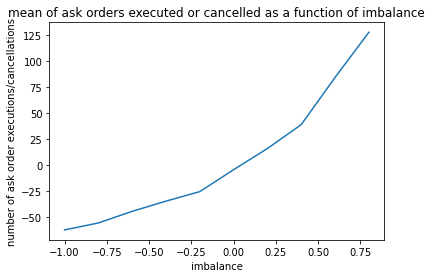

In [13]:
zs = np.zeros(10)
m = np.zeros(10)
for df in dfs:
    i = df["imbalance_bin"].to_numpy()[:-1]
    z1 = df["aq1"].to_numpy()[:-1]
    z2 = df["aq1"].to_numpy()[1:]
    z = z2-z1
    for j in range(10):
        b = (j-5)/5
        n = np.sum(i==b)
        m[j] += n
        zs[j] += n*np.mean(z[i==b])
zs = zs/m
fig,ax = plt.subplots()
ax.plot(np.arange(-1,1,0.2),zs)
ax.set_title("mean of ask orders executed or cancelled as a function of imbalance")
ax.set_xlabel("imbalance")
ax.set_ylabel("number of ask order executions/cancellations");

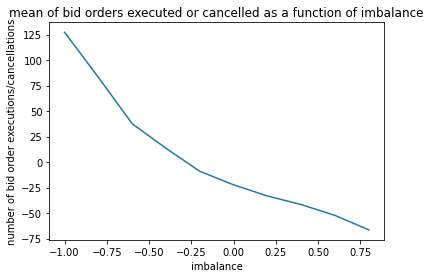

In [14]:
zs = np.zeros(10)
m = np.zeros(10)
for df in dfs:
    i = df["imbalance_bin"].to_numpy()[:-1]
    z1 = df["bq1"].to_numpy()[:-1]
    z2 = df["bq1"].to_numpy()[1:]
    z = z2-z1
    for j in range(10):
        b = (j-5)/5
        n = np.sum(i==b)
        m[j] += n
        zs[j] += n*np.mean(z[i==b])
zs = zs/m
fig,ax = plt.subplots()
ax.plot(np.arange(-1,1,0.2),zs)
ax.set_title("mean of bid orders executed or cancelled as a function of imbalance")
ax.set_xlabel("imbalance")
ax.set_ylabel("number of bid order executions/cancellations");

### Comments:
The executed/cancelled quantites on the ask side increase with the imbalance, which means that when the ask volume is lower than the bid volume, actors of the market interpret it as an underpricing on the sell side.
Similarly, the executed/cancelled quantities on the bid size decrease with the imbalance.

These phenomena explain why the variation of mid price increases with the imbalance: if imbalance is low, the bid orders are executed or cancelled, which means that the mid price is lowered; if imbalance is high, ask orders are executed or cancelled, which  means that the mid price is increased.

## 5. Autocorrelation of trade signs
- Sign the trades of your sample using a tick test.
- Compute the autocorrelation of the trade signs, and comment.

In [15]:
l = os.listdir(path)
tdfs = []
for name in l:
    if "trades" in name:
        tdf = pd.read_csv(path+name)
        tdf["ts"] = pd.to_datetime(tdf["ts"])
        tdf["time_in_s"] = tdf["ts"].dt.hour*3600 + tdf["ts"].dt.minute*60 + tdf["ts"].dt.second + tdf["ts"].dt.microsecond/1000000
        signs = np.zeros(tdf.shape[0])
        z1 = tdf["price"].to_numpy()[:-1]
        z2 = tdf["price"].to_numpy()[1:]
        z = z2-z1
        signs[1:] = np.sign(z)
        tdf["sign"] = signs
        tdf["sign"].replace(to_replace=0, method='ffill', inplace = True)
        tdfs += [tdf]

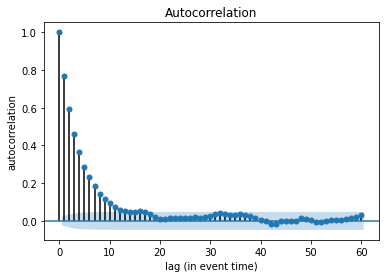

In [16]:
fig,ax = plt.subplots()
plot_acf(x=tdfs[0]["sign"], lags=60, ax = ax)
ax.set_xlabel("lag (in event time)")
ax.set_ylabel("autocorrelation");

### Comments:

The autocorrelation of trade signes decreases slowly as a function of the lag. It means that the trades are not independant from each others.

## 6. Average shape of the LOB
- For each stock, make a bar plot of the average shape of the LOB (one bar per level on each side) in event time.
- For each stock, make the same plot in in calendar time.

In [ ]:
path = "Data/TOTF.PA/"
l = os.listdir(path)
dfs = []
for name in l:
    if "quotes" in name:
        df = pd.read_csv(path+name)
        df["ts"] = pd.to_datetime(df["ts"])
        df["time_in_s"] = df["ts"].dt.hour*3600 + df["ts"].dt.minute*60 + df["ts"].dt.second + df["ts"].dt.microsecond/1000000
        dfs += [df]

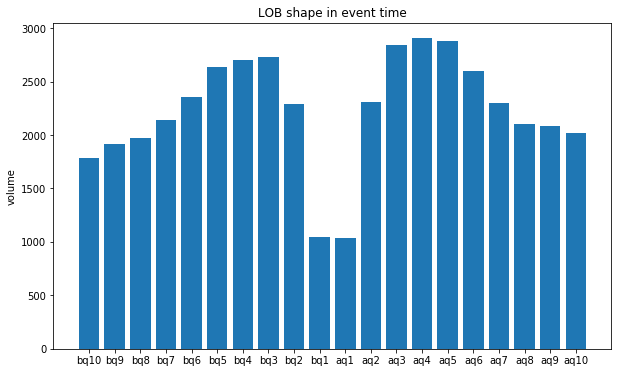

In [ ]:
bar = np.zeros(20)
m = 0
for df in dfs:
    n = df.shape[0]
    m += n
    for i in range(10):
        bar[i] += np.sum(df["bq"+str(10-i)])
        bar[10+i] += np.sum(df["aq"+str(i+1)])
bar = bar/m
fig,ax = plt.subplots(figsize = (10,6))
ax.bar(range(20),bar)
ax.set_xticks(range(20))
ax.set_xticklabels(["bq"+str(10-i) for i in range(10)]+["aq"+str(i+1) for i in range(10)])
ax.set_title("LOB shape in event time")
ax.set_ylabel("volume");

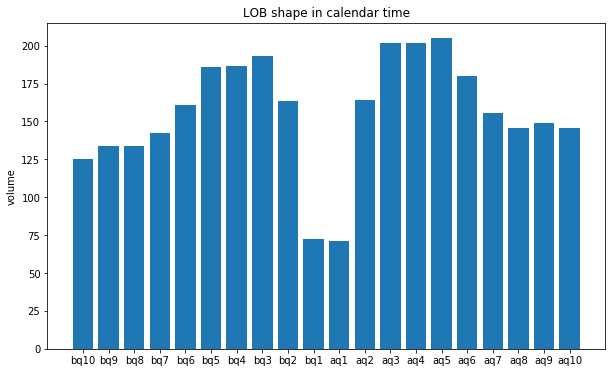

In [ ]:
bar = np.zeros(20)
m = 0
t = 0
for df in dfs:
    n = df.shape[0]
    m += n
    dt = df["time_in_s"].diff()
    for i in range(10):
        bar[i] += np.sum(df["bq"+str(10-i)]*dt.shift(-1))
        bar[10+i] += np.sum(df["aq"+str(i+1)]*dt.shift(-1))
bar = bar/m
fig,ax = plt.subplots(figsize = (10,6))
ax.bar(range(20),bar)
ax.set_xticks(range(20))
ax.set_xticklabels(["bq"+str(10-i) for i in range(10)]+["aq"+str(i+1) for i in range(10)])
ax.set_title("LOB shape in calendar time")
ax.set_ylabel("volume");

## Comments:

The two histograms are similar.